In [ ]:
import argparse
import easydict
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from dataloader import DataLoader as DL
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x
    
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(args, model, device, data_loader, train=False):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    loss /= len(data_loader.dataset)
    accu = 100. * correct / len(data_loader.dataset)
    
    if train:
        print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            loss, correct, len(data_loader.dataset), accu))
    else:
        print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            loss, correct, len(data_loader.dataset), accu))
        
    return (loss, accu)

In [ ]:
args = easydict.EasyDict({
    "batch_size": 256,
    "test_batch_size": 1000,
    "epochs": 40,
    "lr": 0.01, # 0.001 for Adam
    "momentum": 0.9,
    "no_cuda": False,
    "log_interval": 100,
    "save_model": True,
    "n_models": 3
})

In [ ]:
use_cuda = not args.no_cuda and torch.cuda.is_available()


device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

dl = DL(Xtrainpath='./data/train-images-idx3-ubyte.gz',
		Ytrainpath='./data/train-labels-idx1-ubyte.gz',
		Xtestpath='./data/t10k-images-idx3-ubyte.gz',
		Ytestpath='./data/t10k-labels-idx1-ubyte.gz')
Xtrain, Ytrain, Xtest, Ytest = dl.load_data()

trainset = TensorDataset(torch.unsqueeze(torch.tensor(Xtrain.astype(np.float32)), 1), torch.tensor(Ytrain.astype(np.int64)))
testset = TensorDataset(torch.unsqueeze(torch.tensor(Xtest.astype(np.float32)), 1), torch.tensor(Ytest.astype(np.int64)))

In [ ]:
def timer(start,end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Elapsed time is: {:0>2}:{:0>2}:{:05.2f}\n".format(int(hours),int(minutes),seconds))

# generate the model for the full set

In [ ]:
n_model = args.n_models
n_epoch = args.epochs

train_loss = np.zeros((n_epoch, n_model))
test_loss = np.zeros((n_epoch, n_model))
train_accu = np.zeros((n_epoch, n_model))
test_accu = np.zeros((n_epoch, n_model))


for imodel in range(n_model):
    print("\n======== Run random model #%d ========\n" % (imodel))
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size, **kwargs)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=args.test_batch_size, shuffle=True, **kwargs)

    # save the stat_dict for different initializations
    model = CNNNet().to(device)
    torch.save(model.state_dict(), "./ckpts/model_cnn_initialization"+str(imodel))
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
#     optimizer = optim.Adam(model.parameters())
    
    for epoch in range(1, n_epoch + 1):
        start_time = time.time()
        train(args, model, device, train_loader, optimizer, epoch)
        tr_loss, tr_accu = test(args, model, device, train_loader, train=True)
        te_loss, te_accu = test(args, model, device, test_loader, train=False)
        timer(start_time, time.time())
        
        train_loss[epoch-1, imodel] = tr_loss
        train_accu[epoch-1, imodel] = tr_accu
        test_loss[epoch-1, imodel] = te_loss
        test_accu[epoch-1, imodel] = te_accu



======== Run random model #0 ========

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.314629
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.624148
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.694197

Train set: Average loss: 0.3238, Accuracy: 54155/60000 (90%)
Test set: Average loss: 0.3040, Accuracy: 9086/10000 (91%)

Elapsed time is: 00:00:09.18

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.699332
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.463720
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.410005

Train set: Average loss: 0.1850, Accuracy: 56645/60000 (94%)
Test set: Average loss: 0.1722, Accuracy: 9453/10000 (95%)

Elapsed time is: 00:00:09.23

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.426908
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.374714
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.300704

Train set: Average loss: 0.1504, Accuracy: 57242/60000 (95%)
Test set: Average loss: 0.1418, Accuracy: 9547/10000 (95%)

Elapsed time is: 00:00:09.23

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.389856
Train Epoch: 4 [25600/60

In [ ]:
train_loss_mean = np.mean(train_loss, axis=1)
train_accu_mean = np.mean(train_accu, axis=1)
test_loss_mean = np.mean(test_loss, axis=1)
test_accu_mean = np.mean(test_accu, axis=1)

In [ ]:
train_loss_std = np.std(train_loss, axis=1)
train_accu_std = np.std(train_accu, axis=1)
test_loss_std = np.std(test_loss, axis=1)
test_accu_std = np.std(test_accu, axis=1)

# plot all results

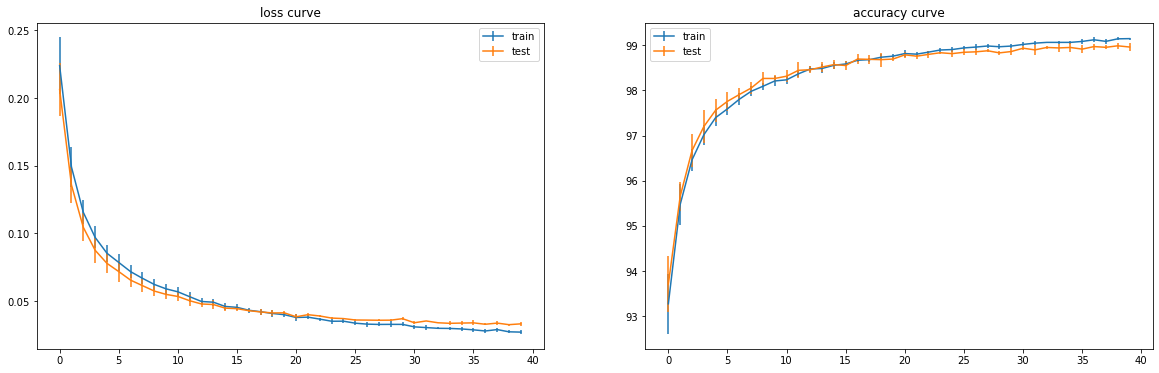

In [ ]:
# plots using Adam optimizer (lr = 0.001)

plt.figure(figsize=(20,6))

plt.subplot(121)
plt.errorbar(range(n_epoch), train_loss_mean, train_loss_std, label='train')
plt.errorbar(range(n_epoch), test_loss_mean, test_loss_std, label='test')
plt.title('loss curve')
plt.legend()

plt.subplot(122)
plt.errorbar(range(n_epoch), train_accu_mean, train_accu_std, label='train')
plt.errorbar(range(n_epoch), test_accu_mean, test_accu_std, label='test')
plt.title('accuracy curve')
plt.legend()

plt.show()

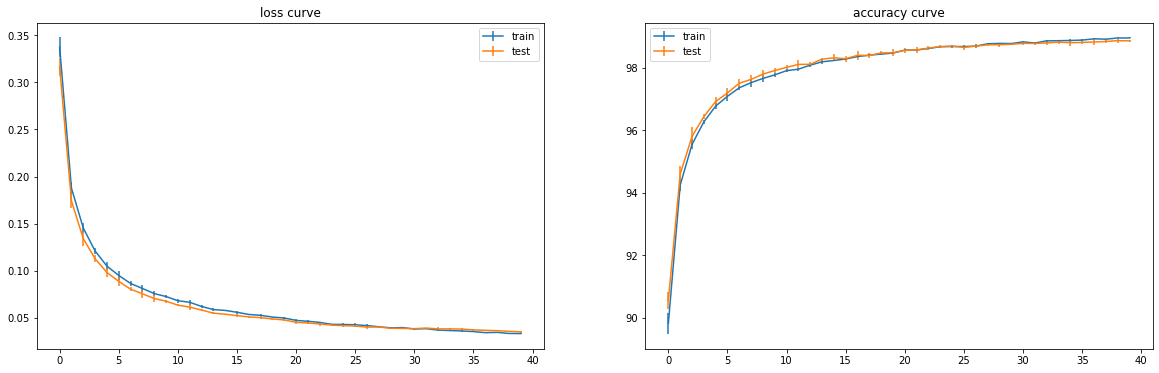

In [ ]:
# plots using SGD optimizer (lr = 0.01) 

plt.figure(figsize=(20,6))

plt.subplot(121)
plt.errorbar(range(n_epoch), train_loss_mean, train_loss_std, label='train')
plt.errorbar(range(n_epoch), test_loss_mean, test_loss_std, label='test')
plt.title('loss curve')
plt.legend()

plt.subplot(122)
plt.errorbar(range(n_epoch), train_accu_mean, train_accu_std, label='train')
plt.errorbar(range(n_epoch), test_accu_mean, test_accu_std, label='test')
plt.title('accuracy curve')
plt.legend()

plt.show()